# Mały projekt 1: wizualizacja poziomu zanieczyszczeń (PM2.5)

Główny Inspektorat Ochrony Środowiska (GIOS) udostępnia dane o jakości powietrza w Polsce na stronie [https://powietrze.gios.gov.pl](https://powietrze.gios.gov.pl), tj. poziom stężenia pyłów PM2.5, PM10, SO2 i innych zanieczyszczeń. Dane te są szczególnie przydatne w analizach środowiskowych i zdrowotnych. W tym zadaniu interesują nas godzinne pomiary stężeń drobnego pyłu **PM2.5** (pyłu o średnicy poniżej 2.5 µm) w latach **2014, 2019 i 2024**. Pyły PM2.5 są one bardzo szkodliwe dla zdrowia, gdyż mogąc przenikać głęboko do układu oddechowego i krwiobiegu. Zadanie polega na przeprowadzeniu analizy danych wraz z opisami czynności oraz wykresami.

## Wymagania ogólne

- Rozwiązanie należy przygotować w formie **Jupyter Notebooka (`.ipynb`)**.  Rozwiązanie proszę przesłać przez Moodle’a.
- Wszystkie operacje czyszczenia i łączenia danych wykonaj **programistycznie**, bez ręcznej edycji plików.
- Do każdego punktu należy obowiązkowo dodać opis z analizą otrzymanych wyników.  
- Zadanie należy wykonać w wylosowanych parach. Obie osoby z pary przesyłają **identyczne pliki** i dodają na początku notebooka opis swojego wkładu.
- Ocena jest wspólna dla pary, a nie indywidualna.

## Dane wejściowe i metadane

- Każdy rok to archiwum ZIP dostępne pod adresem [https://powietrze.gios.gov.pl/pjp/archives/](https://powietrze.gios.gov.pl/pjp/archives/).
- Wewnątrz znajdują się pliki Excel, np. `2024_PM25_1g.xlsx`.
- Poniższa funkcja `download_gios_archive` pozwala odczytać odpowiedni zbior danych; resztę danych pomijamy.
- Użyj pliku metadanych (dostępnego na tej samej stronie), aby zaktualizować **kody stacji** (część stacji mogła w międzyczasie zmienić nazwę). W metadanych znajdziesz odpowiednie kolumny.

## Zadania

### 1. Wczytanie i czyszczenie danych

Wczytaj dane dla lat **2014, 2019 i 2024**, oczyścić je z niepotrzebnych wierszy oraz ujednolić ich format. Zaktualizuj stare kody stacji zgodnie z metadanymi. Pozostaw tylko stacje występujące we wszystkich trzech latach. Informacje o stacjach pomiarowych warto uzupełnić o miejscowości dostępne w metadanych, np. za pomocą MultiIndex: (miejscowość, kod stacji). Pomiary dokonane o północy (00:00:00) powinny być potraktowane jako dotyczące poprzedniego dnia. Połącz dane z trzech lat w jeden `DataFrame` i zapisz do pliku.

### 2. Średnie miesięczne + trend dla miast

Oblicz średnie miesięczne stężenie PM2.5 dla każdej stacji i roku. Dla **Warszawy** i **Katowic**, po uśrednieniu po wszystkich stacjach z tych miast, narysuj wykres liniowy pokazujący trend średnich miesięcznych wartości PM2.5 w 2014 i 2024 roku. Oś X - miesiące (1-12); oś Y - średnia wartość PM2.5; 4 linie trendu. Dołącz opis i interpretację obserwowanych różnic.

### 3. Heatmapa miesięcznych średnich

Dla każdej miejscowości przedstaw heatmapę średnich miesięcznych stężeń PM2.5 w latach lat 2014, 2019 i 2024 (oś X – miesiąc, oś Y – rok). Uśrednij wartości po wszystkich stacjach w danej miejscowości. Każdy panel (facet) ma odpowiadać jednej miejscowości. Dołącz interpretację obserwowanych wyników.

### 4. Dni z przekroczeniem normy (WHO)

Dla każdej stacji i roku policz liczbę dni, w których wystąpiło przekroczenie dobowej normy stężenia PM2.5, czyli 15 µg/m³ (źródło: [https://airscan.org/new-who-air-quality-guidelines-2021/](https://airscan.org/new-who-air-quality-guidelines-2021/)). Znajdź 3 stacje z najmniejszą i 3 stacje z największą liczbą dni z przekroczeniem normy dobowej w 2024 roku. Dla tych 6 stacji narysuj *grouped barplot*, gdzie oś X – stacje, oś Y – liczba dni z przekroczeniem, kolor – rok (2014, 2019, 2024). Dołącz opis i interpretację obserwowanych różnic.

## Dodatkowe wymagania i sugestie

- Notebook powinien zawierać *sanity checks*, np.:
  - liczba stacji w każdym pliku,
  - liczba dni w każdym roku,  
  - kilka przykładowych mapowań kodów stacji,  
- Wszystkie wykresy powinny mieć tytuły, legendy i krótki opis interpretacji.
- Zachęcamy do weryfikacji kodu napisanego przez drugą osobę, gdyż ocena jest wspólna.
- Można wykorzystać dowolne poznane biblioteki do analizy i wizualizacji danych w Pythonie.

## Kryteria oceny

- Zadanie 1: 3 pkt
- Zadanie 2: 2 pkt
- Zadanie 3: 1.5 pkt
- Zadanie 4: 2 pkt
- Jakość wyjaśnień, interpretacje, opis wkładu: 1.5 pkt



In [5]:
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd
import requests
import zipfile
import io, os

In [6]:
# id archiwum dla poszczególnych lat
gios_archive_url = "https://powietrze.gios.gov.pl/pjp/archives/downloadFile/"
gios_url_ids = {2014: '302', 2019: '322', 2024: '582'}
gios_pm25_file = {2014: '2014_PM2.5_1g.xlsx', 2019: '2019_PM25_1g.xlsx', 2024: '2024_PM25_1g.xlsx'}

# funkcja do ściągania podanego archiwum
def download_gios_archive(year, gios_id, filename):
    # Pobranie archiwum ZIP do pamięci
    url = f"{gios_archive_url}{gios_id}"
    response = requests.get(url)
    response.raise_for_status()  # jeśli błąd HTTP, zatrzymaj
    
    # Otwórz zip w pamięci
    with zipfile.ZipFile(io.BytesIO(response.content)) as z:
        # znajdź właściwy plik z PM2.5
        if not filename:
            print(f"Błąd: nie znaleziono {filename}.")
        else:
            # wczytaj plik do pandas
            with z.open(filename) as f:
                try:
                    df = pd.read_excel(f, header=None)
                except Exception as e:
                    print(f"Błąd przy wczytywaniu {year}: {e}")
    return df



In [ ]:
import pandas as pd

def clean_gios_data(df_raw: pd.DataFrame) -> pd.DataFrame:
    """
    Clean GIOŚ PM2.5 data where 6th row contains column names.
    Removes extra header rows and unit rows, converts data to numeric,
    and sets datetime column 'Data'.
    """

    df = df_raw.dropna(how='all').copy()
    df.columns = df.iloc[5]

    df = df_raw.copy()
    df.columns = df.iloc[5]
    df = df.iloc[6:].copy()

    df.rename(columns={df.columns[0]: "Data"}, inplace=True)
    df = df[~df.iloc[:, 1].astype(str).str.contains('1g|ug/m3', na=False)]

    df["Data"] = pd.to_datetime(df["Data"], errors="coerce", format="%Y-%m-%d %H:%M:%S")
    df.iloc[:, 1:] = df.iloc[:, 1:].apply(pd.to_numeric, errors="coerce")

    mask_midnight = df["Data"].dt.hour == 0
    df.loc[mask_midnight, "Data"] -= pd.Timedelta(days=1)

    df.set_index("Data", inplace=True)
    df = df.dropna(how='all', axis=0)

    return df




def clean_gios_2014(df_raw: pd.DataFrame) -> pd.DataFrame:
    """
    Clean GIOŚ PM2.5 2014-format data:
    - use first row as column headers,
    - remove metadata rows,
    - convert the first column to datetime and set as index,
    - convert all measurement columns to numeric.
    """
    df = df_raw.copy()
    df.columns = df.iloc[0]
    df = df.drop(index=0).reset_index(drop=True)
    df.rename(columns={df.columns[0]: "Data"}, inplace=True)
    df = df.dropna(axis=1, how='all')
    df["Data"] = pd.to_datetime(df["Data"], errors="coerce")
    df.set_index("Data", inplace=True)
    df = df.apply(pd.to_numeric, errors="coerce")
    df = df.iloc[2:]
    mask_midnight = df.index.hour == 0
    df.index = df.index - pd.to_timedelta(mask_midnight.astype(int), unit="D")

    return df


In [8]:
df2024_raw = download_gios_archive(2024, gios_url_ids[2024], gios_pm25_file[2024])

In [9]:
df2014_raw = download_gios_archive(2014, gios_url_ids[2014], gios_pm25_file[2014])

c:\Users\Yoga\anaconda3\Lib\site-packages\openpyxl\worksheet\header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


In [10]:
df2019_raw = download_gios_archive(2019, gios_url_ids[2019], gios_pm25_file[2019])

In [38]:
df2019 = clean_gios_data(df2019_raw)
df2024 = clean_gios_data(df2024_raw)
df2014 = clean_gios_2014(df2014_raw)

C:\Users\Yoga\AppData\Local\Temp\ipykernel_30012\3992679997.py:58: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["Data"] = pd.to_datetime(df["Data"], errors="coerce")


In [39]:
num_stations_2014 = df2014.shape[1] 
num_stations_2019 = df2019.shape[1]  
num_stations_2024 = df2024.shape[1]
unique_days_shifted = df2014.index.normalize().unique()

num_days_2014 = len(pd.unique(unique_days_shifted))
num_days_2019 = len(pd.unique(df2019.index.date))
num_days_2024 = len(pd.unique(df2024.index.date))

print(f"Number of days in 2014: {num_days_2014}")
print(f"Number of days in 2019: {num_days_2019}")
print(f"Number of days in 2024: {num_days_2024}")

print(f"\nNumber of stations in 2014: {num_stations_2014}")
print(f"Number of stations in 2019: {num_stations_2019}")
print(f"Number of stations in 2024: {num_stations_2024}")



Number of days in 2014: 365
Number of days in 2019: 365
Number of days in 2024: 366

Number of stations in 2014: 35
Number of stations in 2019: 63
Number of stations in 2024: 96


In [15]:
# TODO - to można dać do wcześniejszych funkcji, 
meta = pd.read_excel("https://powietrze.gios.gov.pl/pjp/archives/downloadFile/584", header=0)
meta["Stary Kod stacji \n(o ile inny od aktualnego)"]

0                               NaN
1                               NaN
2                        DsBogatMob
3                               NaN
4                               NaN
                   ...             
1129    ZpSzczecin002, ZpSzczPils02
1130                            NaN
1131                            NaN
1132                            NaN
1133             ZpGryfWiduchowa003
Name: Stary Kod stacji \n(o ile inny od aktualnego), Length: 1134, dtype: object

In [40]:
# Creating a mapping from old station codes to current station codes using the metadata
mapping = {}
for _, row in meta.dropna(subset=["Stary Kod stacji \n(o ile inny od aktualnego)"]).iterrows():
    old_codes = [c.strip() for c in row["Stary Kod stacji \n(o ile inny od aktualnego)"].split(",")]
    for old in old_codes:
        mapping[old] = row["Kod stacji"]


In [ ]:
def clean_column_names(df):
    """Clean column names to standardize them across different years and simplify station code mapping."""
    df.columns = (
        df.columns.str.strip()
        .str.replace("-PM2.5-1g", "", regex=False)
        .str.replace(" ", "")
    )
    return df


df2019 = clean_column_names(df2019)
df2024 = clean_column_names(df2024)

print(df2014.columns[:10])
print(df2019.columns[:10])
print(df2024.columns[:10])


Index(['DsWrocWisA', 'KpAirpWiktorowo', 'KpBydgPlPozn', 'KpBydgWarszawska',
       'KpTorunDziewulsk', 'LdLodzWIOSACzernik', 'LdZgierzWIOSAMielcza',
       'LuZgoraWIOS_AUT', 'MpKrakowWIOSAKra6117', 'MpKrakowWIOSBuja6119'],
      dtype='object', name=0)
Index(['DsDusznikMOB', 'DsJaworMOB', 'DsJelGorOgin', 'DsWrocAlWisn',
       'DsWrocWybCon', 'KpBydPlPozna', 'KpMogiNowMOB', 'KpToruDziewu',
       'KpWloclOkrze', 'LbLubObywate'],
      dtype='object', name=5)
Index(['DsChojnowMalMOB', 'DsJelGorOgin', 'DsKlodzSzkol', 'DsKudowaSzkoMOB',
       'DsWrocAlWisn', 'DsWrocWybCon', 'KpBydPlPozna', 'KpBydWarszaw',
       'KpNaklWawrzy', 'KpSwiecJPawlMOB'],
      dtype='object', name=5)


In [18]:
df2014.rename(columns=mapping, inplace=True)
df2019.rename(columns=mapping, inplace=True)
df2024.rename(columns=mapping, inplace=True)


In [19]:
common_stations = list(set(df2014.columns) & set(df2019.columns) & set(df2024.columns))
print(f"Liczba wspólnych stacji: {len(common_stations)}")

df2014 = df2014[common_stations]
df2019 = df2019[common_stations]
df2024 = df2024[common_stations]


Liczba wspólnych stacji: 23


In [44]:
combined = pd.concat([df2014, df2019, df2024]).sort_index()
combined = combined.dropna(how="all")

combined.index = pd.to_datetime(combined.index)
combined = combined.sort_index()

print(combined.shape)
print(f"\nCombined df starts on: \n{combined.index.min()} \nand ends on: \n{combined.index.max()}")
#TODO - funkcje podmieniłem tutaj się nie wyświetli bo jest niżej
#combined = fill_na(combined)
combined.to_csv("PM25_combined_2014_2019_2024.csv")
df = combined


(26304, 152)

Combined df starts on: 
2014-01-01 00:00:00 
and ends on: 
2024-12-31 23:00:00


## Zadanie 2
### Metodologia 

>Średnie miesięczne

Do wyliczenia średnich miesięcznych używamy metody:
```Python
time_to_month
```
Otrzymujemy wtedy `df` indeksowany po pierwszym dniu miesiąca, która zawiera średnią wartości emisji z miesiąca zmierzonej w danej stacji.

> 

### Zadanie 2
#### Wyniki
Widzimy, że w 2014 roku stężenie PM2.5 jest około dwa razy większe niż w roku 2024. 

Możemy także zauważyć ....

TODO 
#### Analiza wyników
Wynika to z tego, że w tych latach ... (napisać co zostało zmienione z czego to wynika) 
#### Zadanie 2


In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# helper functions 
def fill_na(df: pd.DataFrame) ->pd.DataFrame:
    '''
    Fills NA values in df by dropping empty values
    #TODO 
    - stworzenie funkcji
    '''
    return df.dropna()


def time_to_month(df: pd.DataFrame) -> pd.DataFrame:
    '''
    Changes time index representation from day to month, by mean aggregating. Returns new df
    \n**df**: Dataframe with time indexes
    '''
    new_df = df.resample('MS').mean()
    return new_df

# musimy mieć funkcje która zbiera województwo i miejscowość

def get_stations(df: pd.DataFrame, cities: list, *, meta=meta) -> list:
    '''
    Return df with columns that met criteria
    \n**df**: Dataframe based on GIOŚ data TODO - tutaj zmienic nazwę po funkcji która te dane przetwarza 
    '''
    filt = meta['Miejscowość'].isin(cities)
    # filt1 = meta['Województwo'].isin(voivodeships)
    # filt = filt1 & filt
    cols_idx = meta[filt]['Kod stacji'].to_list()
    
    df_filtered = df.loc[:, df.columns.isin(cols_idx)]
    return df_filtered

def years_trend_cities(df: pd.DataFrame, cities: list, years: list, *, meta=meta, save=False) -> None:
    '''
    Draw plots how concentration of PM2.5 was changing in given year across different cities
    \n**df**: Dataframe based on GIOŚ data TODO - tutaj zmienic nazwę po funkcji 
    \n**cities**: List of cities to compare 
    \n**years**: List of years we want to compare data
    \n**meta**: Dataframe with meta information about **df**
    \n**save**: TODO If False return None, else save plots in given folder 
    '''
    # Changes time representation: per day -> per month (mean)
    df = time_to_month(df)
    
    # Changes all to all cities
    if cities == 'all':
        # finding all cities in df
        cities = meta[meta['Kod stacji'].isin(df.columns)]['Miejscowość'].to_list()
        cities = list(set(cities))
        print(f"There is {len(cities)}")

    # plots
    for year in years:
        df_loc = df[df.index.year == year]
        for city in cities:
            # Gets stations which met condition
            values = get_stations(df_loc, cities=[city], meta=meta).mean(axis=1)
            # agg for every year 
            if not values.isna().any():
                values.plot(label=city)
        plt.legend()
        plt.title(f'Mean PM2.5 concentration in {year}')
        plt.xlabel('Month')
        plt.ylabel('Concentration of PM2.5')
        plt.ylim((0, df.mean(axis=1).max()*1.25))
        plt.show()

def years_heatmaps_cities(df: pd.DataFrame, cities: list, years: list, *, meta=meta, save=False) -> None:
    '''
    Draw heatmaps Months $\\times$ Years which shows concentration pf PM.2.5
    \n**df**: Dataframe based on GIOŚ data TODO - tutaj zmienic nazwę po funkcji 
    \n**cities**: List of cities to compare 
    \n**years**: List of years we want to compare data
    \n**meta**: Dataframe with meta information about **df**
    \n**save**: TODO If False return None, else save plots in given folder 
    '''
    # Changes time representation: per day -> per month (mean)
    df = df[df.index.year.isin(years)]
    
    df = time_to_month(df)
    # Changes all to all cities
    if cities == 'all':
        # finding all cities in df
        cities = meta[meta['Kod stacji'].isin(df.columns)]['Miejscowość'].to_list()
        cities = list(set(cities))
        print(f"There is {len(cities)}")

   # plots 
    for city in cities:
        val_col = f"city_mean"
        # Gets stations which met condition
        df[val_col] = get_stations(df, cities=[city], meta=meta).mean(axis=1)
        if not df[val_col].isna().any():
            continue 
        # creating pivot table for sns.heatmap
        pivot = pd.pivot_table(df, val_col,df.index.year, df.index.month, aggfunc='mean')
        # plotting pivot table
        sns.heatmap(pivot)
        plt.title(f'Mean PM2.5 concentration in {city}')
        plt.xlabel('Month')
        plt.ylabel('Year')
        #TODO skale ustawić wszędzie taką samą i inny kolor, dostosował bym ją tak, że pokazuje gdzie jest przekroczony poziom zagrażający życiu 
        plt.show()

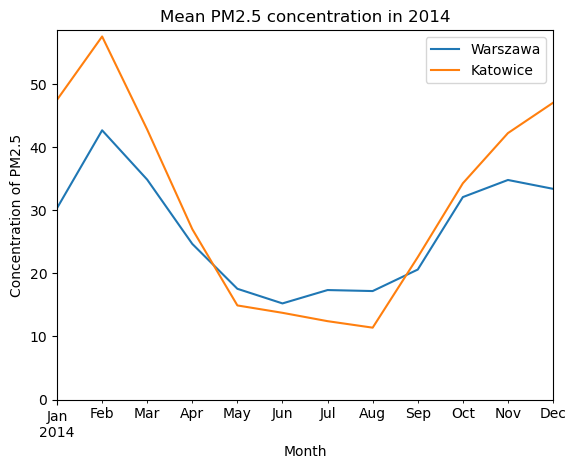

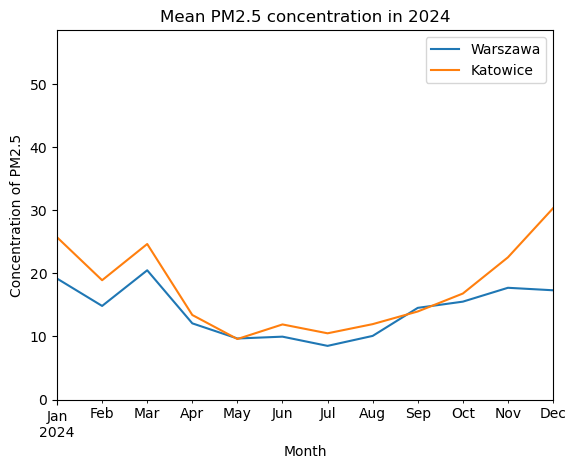

In [22]:
# Exercise 2
cities = ['Warszawa', 'Katowice']
years = [2014, 2024]
years_trend_cities(df, cities=cities, years=years)

There is 20


TypeError: Image data of dtype object cannot be converted to float

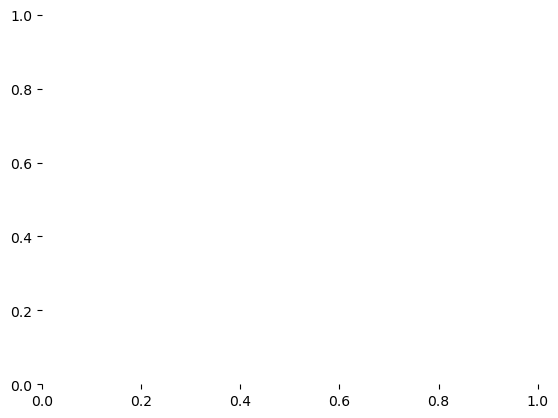

In [23]:
# Exercise 3
cities = ['Warszawa', 'Katowice']
years = [2014, 2019, 2024]
years_heatmaps_cities(df, cities='all', years=years)

4. Dni z przekroczeniem normy (WHO)



In [45]:
daily_mean = 15 

def get_daily_mean(df: pd.DataFrame) -> pd.DataFrame:
    """
    Calculate daily mean PM2.5 values from hourly data.
    """
    daily_df = df.resample("D").mean()  
    return daily_df


def get_daily_exceedances(df: pd.DataFrame, limit: float = daily_mean):
    """
    Identify daily exceedances of the PM2.5 limit for each station.
    """
    daily_df = get_daily_mean(df)       
    exceedances = daily_df > limit      

    total_days_with_exceedances = exceedances.any(axis=1).sum()  

    return exceedances.sum(axis=0), total_days_with_exceedances
    # returns number of exceedance days per station, total days with exceedance


In [ ]:
exc2024, total2024 = get_daily_exceedances(df2024)
exc2019, total2019 = get_daily_exceedances(df2019)
exc2014, total2014 = get_daily_exceedances(df2014)

def top3_bottom3_exceedances(exc: pd.Series) -> tuple[pd.Series, pd.Series]:
    # Finds 3 stations with the highest and 3 with the lowest number of exceedance days and returns them as two Series.
    top3 = exc.sort_values(ascending=False).head(3)
    bottom3 = exc.sort_values().head(3)

    print("Top 3 stations with the most exceedance days:")
    for station, days in top3.items():
        print(f"  {station}: {days}")

    print("\nBottom 3 stations with the fewest exceedance days:")
    for station, days in bottom3.items():
        print(f"  {station}: {days}")

    return top3, bottom3


In [ ]:
print("=== 2024 ===")
top3_2024, bottom3_2024 = top3_bottom3_exceedances(exc2024)


=== 2024 ===
Top 3 stations with the most exceedance days:
  LdZgieMielcz: 189
  MpKrakAlKras: 178
  SlKatoKossut: 165

Bottom 3 stations with the fewest exceedance days:
  ZpSzczAndrze: 72
  MzSiedKonars: 79
  MzWarWokalna: 102


In [ ]:
print("\n=== 2019 ===")
top3_2019, bottom3_2019 = top3_bottom3_exceedances(exc2019)


=== 2019 ===
Top 3 stations with the most exceedance days:
  MzWarAlNiepo: 299
  MpKrakAlKras: 291
  LdZgieMielcz: 244

Bottom 3 stations with the fewest exceedance days:
  PmGdaLeczkow: 71
  LuZielKrotka: 108
  ZpSzczAndrze: 116


In [ ]:
print("\n=== 2014 ===")
top3_2014, bottom3_2014 = top3_bottom3_exceedances(exc2014)


=== 2014 ===
Top 3 stations with the most exceedance days:
  MpKrakAlKras: 351
  MzWarAlNiepo: 306
  WpKaliSawick: 294

Bottom 3 stations with the fewest exceedance days:
  PmGdaLeczkow: 155
  SlZlotPotLes: 165
  ZpSzczAndrze: 176


In [ ]:
selected_stations = list(top3_2024.index) + list(bottom3_2024.index)
plot_df = pd.DataFrame({
    "2014": exc2014[selected_stations],
    "2019": exc2019[selected_stations],
    "2024": exc2024[selected_stations]
})

plot_df = plot_df.T 
plot_df

,LdZgieMielcz,MpKrakAlKras,SlKatoKossut,ZpSzczAndrze,MzSiedKonars,MzWarWokalna
2014,188,351,253,176,247,237
2019,244,291,213,116,190,154
2024,189,178,165,72,79,102


<Figure size 1200x600 with 0 Axes>

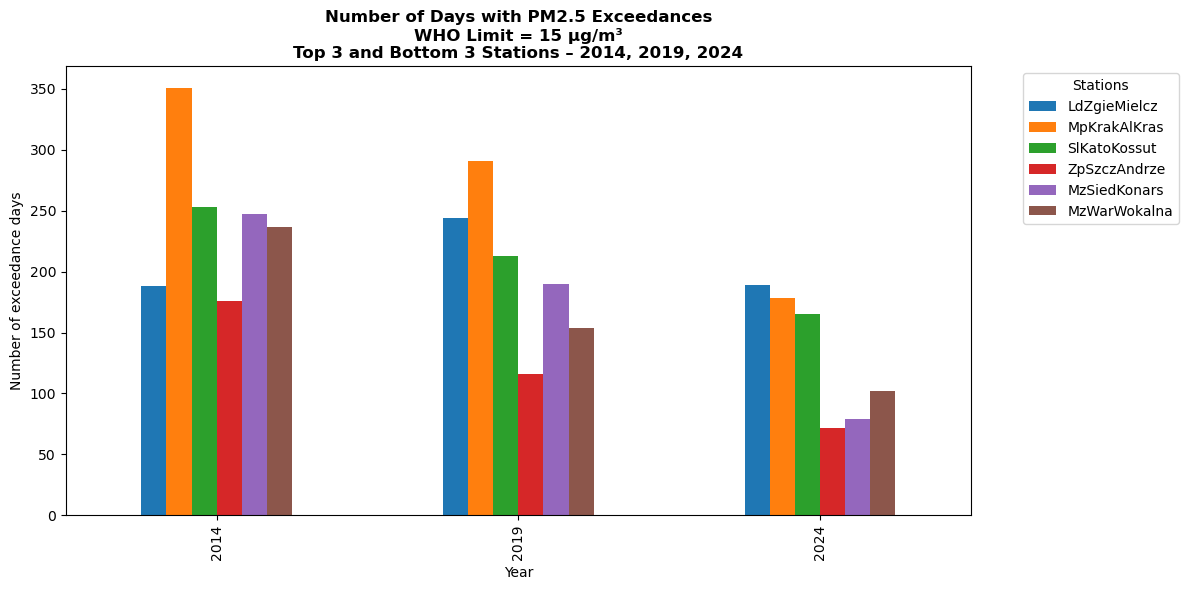

In [ ]:
plt.figure(figsize=(12,6))
plot_df.plot(kind="bar", figsize=(12,6))

plt.title(
    "Number of Days with PM2.5 Exceedances\nWHO Limit = 15 µg/m³\nTop 3 and Bottom 3 Stations - 2014, 2019, 2024",
    fontsize=12,
    fontweight='bold'
)
plt.xlabel("Year")
plt.ylabel("Number of exceedance days")
plt.legend(title="Stations", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Interpretation of PM2.5 Exceedance Days (2014, 2019, 2024)

## 1. Top 3 stations with most exceedance days
- **Stations:** `MpKrakAlKras`, `SlKatoKossut`, `LdZgieMielcz`  
- **Trend:**  
  - `MpKrakAlKras`: 351 days (2014) → 291 days (2019) → 178 days (2024)  
  - `SlKatoKossut` and `LdZgieMielcz`: Similar decreasing trend over the years  
- **Interpretation:** Air quality in the most polluted stations has improved, likely due to emission reductions, traffic regulations, or cleaner heating methods.

## 2. Bottom 3 stations with fewest exceedance days
- **Stations:** `ZpSzczAndrze`, `MzSiedKonars`, `MzWarWokalna`  
- **Trend:**  
  - `ZpSzczAndrze`: 176 → 116 → 72  
  - `MzSiedKonars` and `MzWarWokalna`: Similar decreasing trend  
- **Interpretation:** These areas naturally have cleaner air (less traffic, more greenery), and the improvement over time is also visible.

## 3. General observations
- The gap between the top and bottom stations has narrowed over time.  
- Reduction in exceedance days is strongest in 2024, suggesting effective recent air quality policies or favorable meteorological conditions.  
- Air pollution is spatially heterogeneous: urban and industrial centers have far more days exceeding WHO limits than smaller or cleaner areas.
